<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Exercise 4 | Implement MPC

## Problem 1 | Implement MPC
Consider the discrete-time linear time-invariant system defined by
$$
x^+ = \begin{bmatrix}0.9752 & 1.4544 \\ -0.0327 & 0.9315 \end{bmatrix} x + \begin{bmatrix}0.0248 \\ 0.0327 \end{bmatrix} u
$$
with constraints
$$ \mathcal{X} = \{x \mid |x_1|\leq 5, |x_2|\leq 0.2 \},\quad \mathcal{U} = \{ u \mid |u| \leq 1.75 \} $$

This is a second-order system with a natural frequency of $0.15r/s$, a damping ratio of $\eta= 0.1$, which has been discretized at $1.5r/s$. The first state is the position, and the second is velocity.

Your goal is to implement an MPC controller for this system with a horizon of $N=10$ and a stage cost given by $l(x,u) := 10x^\top x+ u^\top u$.




In [1]:
import numpy as np
from mpt4py import Polyhedron

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# System dynamics
A = np.array([[0.9752, 1.4544], [-0.0327, 0.9315]])
B = np.array([[0.0248], [0.0327]])

# Initial condition
x0 = np.array([3, 0])

# Horizon and cost matrices
N = 10
Q = 10 * np.eye(2)
R = np.eye(1)

# Constraints
# u in U = { u | Mu <= m }
M = np.array([[1], [-1]])
m = np.array([1.75, 1.75])
U = Polyhedron.from_Hrep(M, m)
# x in X = { x | Fx <= f }
F = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
f = np.array([5, 0.2, 5, 0.2])
X = Polyhedron.from_Hrep(F, f)

### Tasks 1

Compute a terminal controller, weight and set that will ensure recursive feasibility and stability of the closed-loop system.

**Hints**:
- You can reuse your code from Exercise 3 to design the terminal set.
- The feedback matrix $K$ and weight matrix $Q_f$ of LQR controller can be computed using the [`dlqr`](https://python-control.readthedocs.io/en/0.10.2/generated/control.dlqr.html#control.dlqr) function in Python Control Toolbox: `from control import dlqr; K, Qf, _ = dlqr(A, B, Q, R)`.

In [ ]:
# ========= [SOLUTION] ============

from control import dlqr
K, Qf, _ = dlqr(A, B, Q, R)
K = -K

print('The terminal weight is Qf=\n', Qf)
print('\nThe terminal controller is u=Kx where K=\n', K)


# Compute maximal invariant set
def max_invariant_set(A_cl, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	O = X
	# TODO: ------------------
	itr = 1
	converged = False
	while itr < max_iter:
		Oprev = O
		F, f = O.A, O.b
		# Compute the pre-set
		O = Polyhedron.from_Hrep(np.vstack((F, F @ A_cl)), np.vstack((f, f)).reshape((-1,)))
		O.minHrep(True)
		_ = O.Vrep  # TODO: this is a tempary fix since the contains() method is not robust enough when both inner and outer polyhera only has H-rep.
		if O == Oprev:
			converged = True
			break
		print('Iteration {0}... not yet converged\n'.format(itr))
		itr += 1
	
	if converged:
		print('Maximum invariant set successfully computed after {0} iterations.'.format(itr))
	# TODO: ------------------

	return O

A_cl = A + B @ K
KU = Polyhedron.from_Hrep(U.A @ K, U.b)
O_inf = max_invariant_set(A_cl, X.intersect(KU))

The terminal weight is Qf=
 [[ 37.0252152   68.38496038]
 [ 68.38496038 407.11769797]]

The terminal controller is u=Kx where K=
 [[ -1.64778648 -11.83442686]]
Iteration 1... not yet converged

Iteration 2... not yet converged

Maximum invariant set successfully computed after 3 iterations.


### Task 2
<!-- 
Compute the sets and weights using your code from last week, and then repeat the procedure
to validate your results using `mpt4py` as follows: 
-->

Compute the matrices and vector so that the MPC problem can be solved using the Quadratic Programming solver [*PIQP*](https://predict-epfl.github.io/piqp/), which solves the optimization problem with the following form:

$$ \begin{aligned} \min_{x} \quad & \frac{1}{2} x^\top P x + c^\top x\\  \text{s.t.}\quad & Ax=b, \\ & h_l \leq Gx \leq h_u \\ & x_l \leq x \leq x_u. \end{aligned} $$

You must check the solver status every time you call an optimization routine to confirm that an optimal solution was found (only if `status == piqp.PIQP_SOLVED`).



In [3]:
nx, nu = B.shape

# TODO: ------------------
# Equality constraints
# A_qp = [
# 	 I,        ...,      |
#   -A,  I,    ...,      |  -B,        
#	    -A, I, ...,      |      -B,
# 	           ...       |     ...
#	             -A, I,  |           -B
# ]
A_qp_left = np.kron(np.eye(N+1), np.eye(nx))
A_qp_left += np.vstack([
    np.zeros((nx, nx*(N+1))),
    np.hstack([np.kron(np.eye(N), -A), np.zeros((N*nx, nx))])
])
A_qp_right = np.zeros((A_qp_left.shape[0], N*nu))
A_qp_right[nx:, :] += np.kron(np.eye(N), -B)
A_qp = np.hstack([A_qp_left, A_qp_right])

b_qp = np.concatenate([x0, np.zeros((N)*nx)])

# Inequality constraints G*x <= h
G_blocks = [np.kron(np.eye(N), X.A), O_inf.A, np.kron(np.eye(N), U.A)]
from scipy.linalg import block_diag
G_qp = block_diag(*G_blocks)

h_u_qp = np.concatenate([
    np.kron(np.ones((N, 1)), X.b).reshape(-1,),
    O_inf.b,
    np.kron(np.ones((N, 1)), U.b).reshape(-1,)
])
h_l_qp = -np.inf * np.ones_like(h_u_qp)

# Cost function 1/2*x'*P*x
P_blocks = [np.kron(np.eye(N), Q), Qf, np.kron(np.eye(N), R)]
P_qp = block_diag(*P_blocks)
c_qp = np.zeros((P_qp.shape[0],))
# TODO: ------------------

# Setup the qp solver
import piqp
qp_solver = piqp.DenseSolver()
qp_solver.setup(P=P_qp, c=c_qp, A=A_qp, b=b_qp, G=G_qp, h_l=h_l_qp, h_u=h_u_qp)
status = qp_solver.solve()
print(status)
# assert status == piqp.PIQP_SOLVED

Status.PIQP_SOLVED


### Task 3
Simulate the closed-loop system starting from the state $x = [3, ~ 0]^\top$. Confirm that your constraints are met. Change the tuning parameters $Q$ and $R$. Does the system respond as expected?

In [4]:
# Closed-loop simulation of the state and input trajectories
def plot_trajs(t_traj_closed_loop: np.ndarray, 
               x_traj_closed_loop: np.ndarray,
               u_traj_closed_loop: np.ndarray):
	# Visualization of the trajectories
	fig, ax = plt.subplots(3, 1, sharex=True)
	ax[0].plot(t_traj_closed_loop, x_traj_closed_loop[0, :], label=r'$p$')
	ax[0].plot(t_traj_closed_loop, 5 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[0].plot(t_traj_closed_loop, -5 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[0].grid()
	ax[0].set_ylabel('x1')

	ax[1].plot(t_traj_closed_loop, x_traj_closed_loop[1, :], label=r'$v$')
	ax[1].plot(t_traj_closed_loop, 0.2 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[1].plot(t_traj_closed_loop, -0.2 * np.ones_like(t_traj_closed_loop), color='red', linestyle='--')
	ax[1].grid()
	ax[1].set_ylabel('x2')

	ax[2].plot(t_traj_closed_loop[:-1], u_traj_closed_loop[0, :], label=r'$a$')
	ax[2].plot(t_traj_closed_loop[:-1], 1.75 * np.ones_like(t_traj_closed_loop[:-1]), color='red', linestyle='--')
	ax[2].plot(t_traj_closed_loop[:-1], -1.75 * np.ones_like(t_traj_closed_loop[:-1]), color='red', linestyle='--')
	ax[2].grid()
	ax[2].set_ylabel('u')
	ax[2].set_xlabel('steps')

	fig.suptitle('Closed-loop trajectory')
	fig.align_ylabels()
	plt.show()

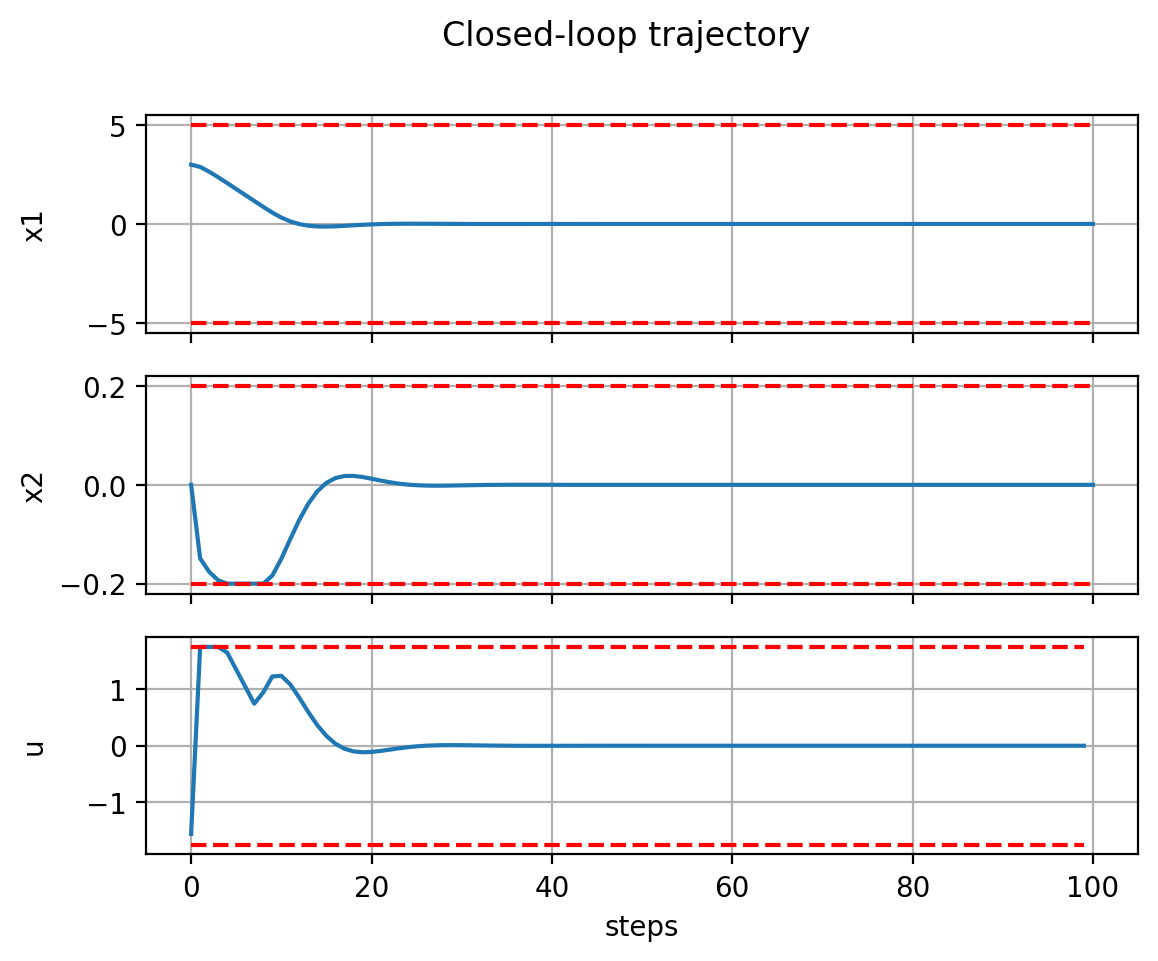

In [5]:
N_closed_loop = 100
t_traj_closed_loop = np.arange(0, N_closed_loop+1)
x_traj_closed_loop = np.zeros((nx, N_closed_loop+1))
u_traj_closed_loop = np.zeros((nu, N_closed_loop))

x_traj_closed_loop[:, 0] = x0
xk = x0

# Closed-loop simulation
for k in range(N_closed_loop):
    # TODO: ------------------
    # TODO: add your code here
    # update the x0 parameter in QP
    b_qp[:nx] = xk
    qp_solver.update(b=b_qp)
    # TODO: ------------------

    status = qp_solver.solve()
    assert status == piqp.PIQP_SOLVED
    
	# TODO: ------------------
    # TODO: add your code here
    # extract the optimal input u0
    uk = qp_solver.result.x[(N+1)*nx:(N+1)*nx+nu]
    # TODO: ------------------
    
	# update
    xk = A @ xk + B @ uk
    x_traj_closed_loop[:, k+1] = xk.flatten()
    u_traj_closed_loop[:, k] = uk.flatten()

plot_trajs(t_traj_closed_loop, x_traj_closed_loop, u_traj_closed_loop)    

## Problem 2 | Implement MPC using CVXPY

Repeat the first exercise, but now make use of the Python optimization toolbox CVXPY. 

### Task 1

Implement your controller from the first exercise again, now using CVXPY. Confirm that the
solution is the same.

In [6]:
import cvxpy as cp

# Define variables
nx, nu = B.shape
x_var = cp.Variable((nx, N + 1), name='x')
u_var = cp.Variable((nu, N), name='u')
x0_var = cp.Parameter((nx,), name='x0')

# Costs
# TODO: ------------------
# TODO: add your code here
cost = 0
for i in range(N):
	cost += cp.quad_form(x_var[:,i], Q)
	cost += cp.quad_form(u_var[:,i], R)
# Terminal cost
cost += cp.quad_form(x_var[:, -1], Qf)
# TODO: ------------------


# Constraints
# TODO: ------------------
# TODO: add your code here
constraints = []
# Initial condition
constraints.append(x_var[:, 0] == x0_var)
# System dynamics
constraints.append(x_var[:,1:] == A @ x_var[:,:-1] + B @ u_var)
# State constraints
constraints.append(X.A @ x_var[:, :-1] <= X.b.reshape(-1, 1))
# Input constraints
constraints.append(U.A @ u_var <= U.b.reshape(-1, 1))
# Terminal Constraints
constraints.append(O_inf.A @ x_var[:, -1] <= O_inf.b.reshape(-1, 1))
# TODO: ------------------

ocp = cp.Problem(cp.Minimize(cost), constraints)

### Task 2
Plot the position, velocity and input of the system. Confirm that your solution is the same
as for exercise 1.

d:\anaconda3\envs\mpc2025\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


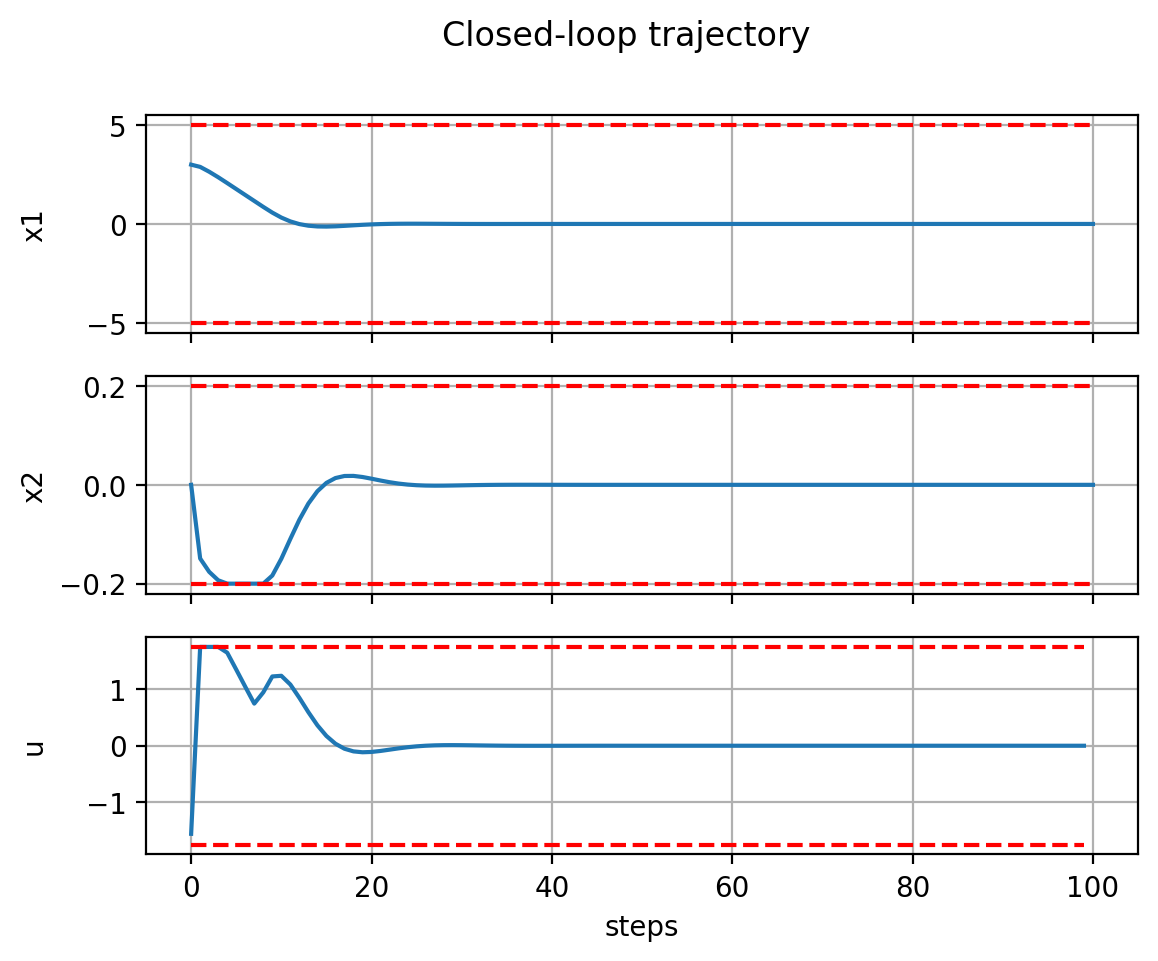

In [7]:
# Closed-loop simulation of the state and input trajectories
N_closed_loop = 100
t_traj_closed_loop = np.arange(0, N_closed_loop+1)
x_traj_closed_loop = np.zeros((nx, N_closed_loop+1))
u_traj_closed_loop = np.zeros((nu, N_closed_loop))

x_traj_closed_loop[:, 0] = x0
xk = x0

# Closed-loop simulation
for k in range(N_closed_loop):
    # TODO: ------------------
	# TODO: add your code here
    x0_var.value = xk
    # TODO: ------------------
    
    ocp.solve()
    assert ocp.status == cp.OPTIMAL
    
	# TODO: ------------------
	# TODO: add your code here
    uk = u_var.value[:, 0]
    # TODO: ------------------

	# update
    xk = A @ xk + B @ uk
    x_traj_closed_loop[:, k+1] = xk.flatten()
    u_traj_closed_loop[:, k] = uk.flatten()
    
plot_trajs(t_traj_closed_loop, x_traj_closed_loop, u_traj_closed_loop)    
